### Example operations

In [1]:
import data as d
import matplotlib.pyplot as plt
import numpy as np
import ants

Defining the dataset object:

In [2]:
dataset=d.dataset('/media/Olowoo/Work/CR/Test_task')

But first, let's see if the general parameters of the scans make sense:

In [3]:
dataset.check_scan_params()

Average spacing [ 1.5        2.4000001 10.         0.3125   ]
spacing standard deviation [0. 0. 0. 0.]
spacing median: [ 1.5        2.4000001 10.         0.3125   ]
spacing mode: [[[ 1.5        2.4000001 10.         0.3125   ]]]
Outliers:
No spacing outliers found
Average shape [128.  80.  17. 158.]
shape standard deviation [0. 0. 0. 0.]
shape median: [128.  80.  17. 158.]
shape mode: [[[128  80  17 158]]]
Outliers:
No shape outliers found


(array([[ 1.5      ,  2.4000001, 10.       ,  0.3125   ],
        [ 1.5      ,  2.4000001, 10.       ,  0.3125   ],
        [ 1.5      ,  2.4000001, 10.       ,  0.3125   ],
        [ 1.5      ,  2.4000001, 10.       ,  0.3125   ],
        [ 1.5      ,  2.4000001, 10.       ,  0.3125   ],
        [ 1.5      ,  2.4000001, 10.       ,  0.3125   ]]),
 array([[128,  80,  17, 158],
        [128,  80,  17, 158],
        [128,  80,  17, 158],
        [128,  80,  17, 158],
        [128,  80,  17, 158],
        [128,  80,  17, 158]]))

Let's now try those different sets of parameters and see how they perform for motion correction. To save time, we only use 3 samples.

In [4]:
alignment_parameters =[{'type_of_transform':'BOLDRigid',
                        'aff_sampling':32,
                        'aff_random_sampling_rate':0.2,
                        'aff_iterations':(100, 500, 50),
                        'aff_smoothing_sigmas':(2, 1, 0),
                        'aff_shrink_factors':(4, 2, 1)
                        },
                       {'type_of_transform':'BOLDRigid',
                        'aff_sampling':16,
                        'aff_random_sampling_rate':0.2,
                        'aff_iterations':(50, 25, 10),
                        'aff_smoothing_sigmas':(2, 1, 0),
                        'aff_shrink_factors':(4, 2, 1)
                        }]

results = dataset.calibrate_motion_correction(alignment_parameters, range(3))
print(results)

[(0.30117741271947757, 40.789008696873985), (0.3272586393912759, 36.928400913874306)]


It seems the second methos is faster, but we have a lower performance (larger standardized error, the first number in the tuple). Since we want this demonstration to go fast, let's pick that one.

In [5]:
dataset.default_motion_correction = alignment_parameters[1]
motionc_err = dataset.motioncorrect_all()

We get a score for every volume in each 4D data series. Let's average them, and have an histogram of the error metric for each series:

(array([1., 1., 1., 0., 1., 0., 0., 1., 0., 1.]),
 array([0.30866387, 0.3201835 , 0.33170312, 0.34322275, 0.35474237,
        0.366262  , 0.37778162, 0.38930125, 0.40082088, 0.4123405 ,
        0.42386013]),
 <BarContainer object of 10 artists>)

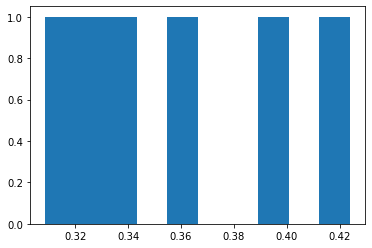

In [6]:
plt.hist(np.array(motionc_err).mean(1))

We can check which volume has the largest error, however they all seem evenly distributed in an interval. It would be:

In [7]:
np.argmax(np.array(motionc_err).mean(1))

5

And we could access it just like this:

In [8]:
dataset[5]

'/media/Olowoo/Work/CR/Test_task/205/raw_phMRIscan.nii.gz'

Now for the registration parameters: we can again explore different configurations, and use mutual information as a quality metric. We changed the sign in the dataset module to be consistent with the previous error measure, where bigger is worse.

In [9]:
registration_parameters=[{'type_of_transform': 'Similarity',
                          'aff_sampling': 16,
                          'aff_random_sampling_rate': 0.4,
                          'aff_iterations': (500, 100, 10),
                          'aff_smoothing_sigmas': (2, 1, 0),
                          'aff_shrink_factors': (4, 2, 1),
                          },
                         {'type_of_transform': 'Similarity',
                          'aff_sampling': 32,
                          'aff_random_sampling_rate': 0.2,
                          'aff_iterations': (5000, 3000, 3000),
                          'aff_smoothing_sigmas': (2, 1, 0),
                          'aff_shrink_factors': (4, 2, 1),
                          }]
registration_info = dataset.calibrate_registration(registration_parameters)
print(registration_info)


[(0.3699080974835123, 1.541954795519511), (0.40917784845693883, 1.7413692077000935)]


This is a lot faster: we are really only aligning two volumes. 

(array([2., 0., 0., 0., 0., 0., 2., 1., 0., 1.]),
 array([0.36227213, 0.37038128, 0.37849044, 0.38659959, 0.39470875,
        0.40281791, 0.41092706, 0.41903622, 0.42714537, 0.43525453,
        0.44336368]),
 <BarContainer object of 10 artists>)

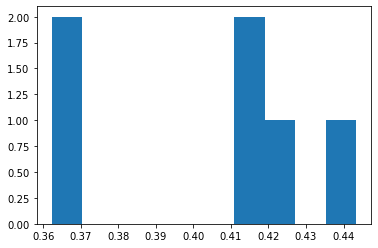

In [10]:
dataset.default_registration = registration_parameters[0]
reg_errs = dataset.register_all()
plt.hist(reg_errs)

Let's see the least-aligned one:

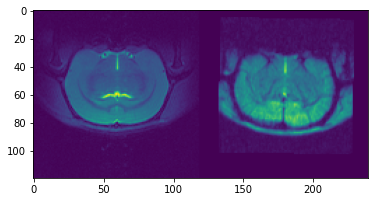

In [16]:
def rescale_intensity(x):
    # This will just help us with visualizing two images
    # on the same scale
    a = x-x.mean()
    return a/a.max()

index = np.argmax(reg_errs)
template = rescale_intensity(ants.image_read(dataset.template))
shifted = rescale_intensity(ants.image_read(dataset.regscans[index]))
comparison = np.concatenate([template[:,:,9].T, shifted[:,:,9,60].T],1)
plt.imshow(comparison)


Let's do the same with the best aligned one:

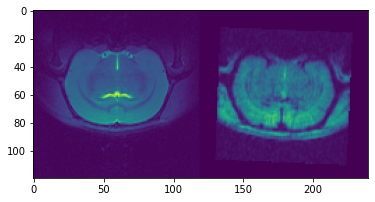

In [18]:
index = np.argmin(reg_errs)
template = rescale_intensity(ants.image_read(dataset.template))
shifted = rescale_intensity(ants.image_read(dataset.regscans[index]))
comparison = np.concatenate([template[:,:,9].T, shifted[:,:,9,60].T],1)
plt.imshow(comparison)

It does not seem there are any outliers as far as image alignment is concerned.